# FOMO - Faster Objects, More Objects

### Import modules

In [255]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

import pytorch_lightning as pl


### BoundingBoxToMask

In [274]:
class BoundingBoxToMask():
    '''Converts YOLO bounding boxes to FOMO centroids'''
    def __init__(self, image_resolution: int, grid_scale: int, number_of_classes: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale
        self._number_of_classes = number_of_classes

    def __call__(self, label):
        grid_resolution = int(self._image_resolution / self._grid_scale)
        
        masks = []

        for i in range(self._number_of_classes):
            class_mask = torch.zeros((grid_resolution, grid_resolution), dtype=int)
            bounding_boxes = label.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, _, _] = [float(coords) for coords in bounding_box.split()]  # get bounding box class, position and dimension
                if c == i:
                    xp_idx = int(x * grid_resolution)
                    yp_idx = int(y * grid_resolution)
                    class_mask[yp_idx, xp_idx] = 1.0
            
            masks.append(class_mask)
        
        return torch.stack(masks).double()

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,

### Dataset

In [257]:
class VehicleDataset(Dataset):
    def __init__(self, dataset_dir: Path, subset: list[str], transform=None, target_transform=None):
        self._images = [dataset_dir / 'images' / (element + ".jpg") for element in subset]
        self._bounding_boxes = [dataset_dir / 'labels' / (element + ".txt") for element in subset]
        self._transform = transform
        self._target_transform = target_transform
    
    def __getitem__(self, idx: int):
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image.float())

        bounding_box_path = self._bounding_boxes[idx]
        bounding_box_file = open(bounding_box_path)
        mask = self._target_transform(bounding_box_file)        

        return image, mask

    def __len__(self):
        return len(self._images)

### DataModule

In [258]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(self, dataset_dir: Path, input_resolution: int, grid_scale: int = 8, batch_size: int = 32):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution   # model input image resolution (assume input is squared shape)
        self._grid_scale = grid_scale  # number of pixels per cell on prediction grid (vertically and horizontally)
        self._batch_size = batch_size
        
        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale, 1)
        self._train_dataset = None
        self._val_dataset = None

    def setup(self, stage: str):
        data_names = sorted([data_name for data_name in (self._dataset_dir / 'images').iterdir()])
        train_names, val_names = random_split(data_names, [0.85, 0.15])
        self._train_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in train_names.indices], self._transform, self._target_transform)
        self._val_dataset = VehicleDataset(self._dataset_dir, [data_names[idx].stem for idx in val_names.indices], self._transform, self._target_transform)
        
    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size)

### FOMO network architecture

In [259]:
def fomo_net(weights: None, number_of_classes: int) -> nn.Module:
    """
    Constructs a FOMO net model with a specified number of classes.
    Input resolution is decreased by a factor of 8.
    """
    model = mobilenet_v2(weights=weights)

    # Remove layers after 1/8 reduction
    cut_inverted_residual = 7
    features = [
        nn.Identity() if i > cut_inverted_residual else model.features[i]
        for i, _ in enumerate(model.features)
    ]
    features[cut_inverted_residual].conv[1] = nn.Identity()
    features[cut_inverted_residual].conv[2] = nn.Identity()
    features[cut_inverted_residual].conv[3] = nn.Identity()
    model = nn.Sequential(*features)

    # Add classification layers
    model.classifier = nn.Sequential(
        nn.Conv2d(in_channels=192, out_channels=32, kernel_size=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=32, out_channels=number_of_classes, kernel_size=1, stride=1
        ),
    )
    return model

### LightningModule

In [260]:
class FomoModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self._network = fomo_net(weights=MobileNet_V2_Weights.DEFAULT, number_of_classes=1)
        self._loss_function = nn.BCEWithLogitsLoss()  # !!!

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self._network(inputs)

    def training_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

### Model training

In [261]:
DATASET_DIR = Path('data')
IMAGE_RESOLUTION = 224 #int(1280 / 4)
GRID_SCALE = 8

In [276]:
fomo_module = FomoModule()
vehicle_data_module = VehicleDataModule(dataset_dir=DATASET_DIR, input_resolution=IMAGE_RESOLUTION, grid_scale=GRID_SCALE)

trainer = pl.Trainer(max_epochs=1)
trainer.fit(model=fomo_module, datamodule=vehicle_data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type              | Params
-----------------------------------------------------
0 | _network       | Sequential        | 68.2 K
1 | _loss_function | BCEWithLogitsLoss | 0     
-----------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mateusz/Desktop/INZYNIERKA/FOMO/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/mateusz/Desktop/INZYNIERKA/FOMO/.venv/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/home/mateusz/Desktop/INZYNIERKA/FOMO/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.84it/s, v_num=35, train_loss=0.469]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s, v_num=35, train_loss=0.469]


### TESTS

In [263]:
vehicle_data_module.setup(stage=None)
train_loader = vehicle_data_module.train_dataloader()
data = next(iter(train_loader))

torch.Size([1, 28, 28])
There are 8 objects in the picture


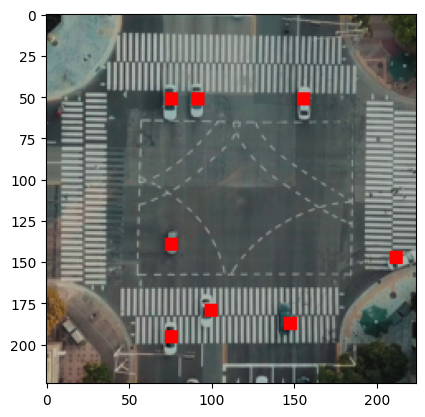

In [275]:
data_idx = 30
image = data[0][data_idx]
mask = data[1][data_idx]

print(mask.shape)

mask = torch.squeeze(mask, dim=0)

image = image.permute(1, 2, 0).numpy().astype(int)
mask = mask.numpy()

mask_res = cv2.resize(mask, dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION), interpolation=cv2.INTER_NEAREST)
image[mask_res == 1] = [255, 0, 0]
plt.imshow(image)

cnt = np.count_nonzero(mask == 1)
print("There are", str(cnt), "objects in the picture")